# Reco-Modell erstellen

In [1]:
import pandas as pd
import re
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
import joblib

# Daten laden

In [2]:
bgdata = pd.read_pickle("../data/bg_data20240412.pkl")

In [3]:
bgdata.head()

,id,name,yearpublished,rank,bayesaverage,average,usersrated,abstracts_rank,cgs_rank,childrensgames_rank,...,boardgameintegration,boardgamegraphicdesigner,boardgameeditor,boardgamewriter,boardgamesculptor,boardgamesolodesigner,boardgamecompilation,boardgameinsertdesigner,boardgame,boardgameissuearticle
0,224517,Brass: Birmingham,2018,1,8.41720,8.60057,43723,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,161936,Pandemic Legacy: Season 1,2015,2,8.38410,8.53050,52692,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,174430,Gloomhaven,2017,3,8.36528,8.59903,61211,NaN,NaN,NaN,...,"['Frosthaven', 'Gloomhaven: Jaws of the Lion',...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,342942,Ark Nova,2021,4,8.33138,8.53762,40218,NaN,NaN,NaN,...,NaN,"['Steffen Bieker', 'Christof Tisch']","['Frank Heeren', 'Inga Keutmann', 'Bastian Win...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,233078,Twilight Imperium: Fourth Edition,2017,5,8.24165,8.60615,22955,NaN,NaN,NaN,...,NaN,Shaun Boyke,NaN,"['Adam Baker', 'Daniel Clark (I)']",NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Doppelte Spalten "name" umbenennen:
colnames = bgdata.columns.tolist()
for y, new in zip([i for i, n in enumerate(bgdata.columns) if n == "name"], ["name", "other_names"]):
    colnames[y] = new
bgdata.columns = colnames

In [5]:
# weitere doppelte Spalten entfernen
bgdata = bgdata.loc[:,~bgdata.columns.duplicated()].copy()

In [6]:
bgdata.columns

Index(['id', 'name', 'yearpublished', 'rank', 'bayesaverage', 'average',
       'usersrated', 'abstracts_rank', 'cgs_rank', 'childrensgames_rank',
       'familygames_rank', 'partygames_rank', 'strategygames_rank',
       'thematic_rank', 'wargames_rank', 'minplayers', 'maxplayers',
       'playingtime', 'minplaytime', 'maxplaytime', 'age', 'other_names',
       'description', 'thumbnail', 'image', 'boardgameaccessory',
       'boardgamepublisher', 'cardset', 'boardgamepodcastepisode',
       'boardgamehonor', 'boardgamecategory', 'videogamebg',
       'boardgamedesigner', 'boardgameartist', 'boardgameversion',
       'boardgamefamily', 'boardgamemechanic', 'boardgamesubdomain',
       'boardgameimplementation', 'suggested_numplayers',
       'language_dependence', 'suggested_playerage', 'rpgpodcastepisode',
       'boardgameexpansion', 'boardgamedeveloper', 'boardgameintegration',
       'boardgamegraphicdesigner', 'boardgameeditor', 'boardgamewriter',
       'boardgamesculptor', 'boa

# Categories vercoden

In [7]:
bgdata["boardgamecategory"] = bgdata.boardgamecategory.apply(lambda x: re.sub("['\[\]^\s+]", '', x).split(","))

In [8]:
categories = pd.get_dummies(bgdata.boardgamecategory.apply(pd.Series), prefix = "cat")

In [9]:
categories = categories.groupby(categories.columns, axis=1).max()

In [10]:
# Top-Kategorien ermitteln
topcat = categories.sum().sort_values(ascending=False).index.to_list()

In [11]:
# Nach Top-Kategorien sortieren
categories = categories[topcat].copy()

In [12]:
# 20 Komponenten extrahieren
ncomp = 20
pca = PCA(n_components=ncomp)
pca.fit(categories)
joblib.dump(pca, "../data/pca_cat.pkl")

['../data/pca_cat.pkl']

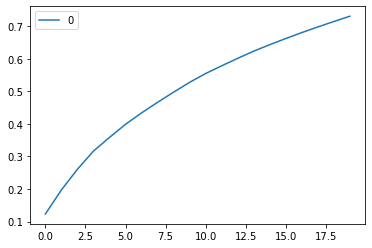

In [13]:
pd.DataFrame(pca.explained_variance_ratio_).cumsum().plot()

In [14]:
categories_pca = pd.DataFrame(pca.transform(categories), columns=["catp_" + str(x) for x in range(ncomp)])

In [15]:
bgdata = pd.concat([bgdata,categories_pca], axis=1)

# Mechanik

In [16]:
bgdata["boardgamemechanic"] = bgdata.boardgamemechanic.apply(lambda x: re.sub("['\[\]^\s+]", '', x).split(","))

In [17]:
mechanic = pd.get_dummies(bgdata.boardgamemechanic.apply(pd.Series), prefix = "mec")

In [18]:
mechanic = mechanic.groupby(mechanic.columns, axis=1).max()

In [19]:
# Top-Mechaniken ermitteln (später für Reco-Datensatz)
topmec = mechanic.sum().sort_values(ascending=False).index.to_list()

In [20]:
# Nach Top-Mechaniken sortieren
mechanic = mechanic[topmec].copy()

In [21]:
ncomp = 20
pca = PCA(n_components=ncomp)
pca.fit(mechanic)

PCA(n_components=20)

In [22]:
joblib.dump(pca, "../data/pca_mec.pkl")

['../data/pca_mec.pkl']

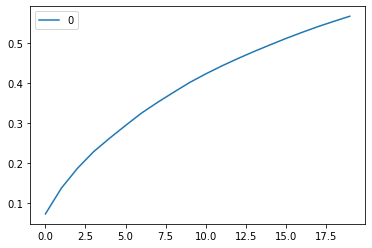

In [23]:
pd.DataFrame(pca.explained_variance_ratio_).cumsum().plot()

In [24]:
mechanic_pca = pd.DataFrame(pca.transform(mechanic), columns=["mecp_" + str(x) for x in range(ncomp)])

In [25]:
bgdata = pd.concat([bgdata,mechanic_pca], axis=1)

In [26]:
bgdata.columns

Index(['id', 'name', 'yearpublished', 'rank', 'bayesaverage', 'average',
       'usersrated', 'abstracts_rank', 'cgs_rank', 'childrensgames_rank',
       'familygames_rank', 'partygames_rank', 'strategygames_rank',
       'thematic_rank', 'wargames_rank', 'minplayers', 'maxplayers',
       'playingtime', 'minplaytime', 'maxplaytime', 'age', 'other_names',
       'description', 'thumbnail', 'image', 'boardgameaccessory',
       'boardgamepublisher', 'cardset', 'boardgamepodcastepisode',
       'boardgamehonor', 'boardgamecategory', 'videogamebg',
       'boardgamedesigner', 'boardgameartist', 'boardgameversion',
       'boardgamefamily', 'boardgamemechanic', 'boardgamesubdomain',
       'boardgameimplementation', 'suggested_numplayers',
       'language_dependence', 'suggested_playerage', 'rpgpodcastepisode',
       'boardgameexpansion', 'boardgamedeveloper', 'boardgameintegration',
       'boardgamegraphicdesigner', 'boardgameeditor', 'boardgamewriter',
       'boardgamesculptor', 'boa

# X_Train

In [27]:
allfeat = ['yearpublished', 'playingtime', 'age'] 

In [28]:
feat = allfeat + ["catp_" + str(x) for x in range(ncomp)] + ["mecp_" + str(x) for x in range(ncomp)]

In [29]:
x_train = bgdata[feat].copy()

In [30]:
#z-Transformation
scaler = StandardScaler()
for x in allfeat:
     x_train[x] = scaler.fit_transform(x_train[x].values.reshape(-1, 1))
     joblib.dump(scaler, f"../data/scaler_{x}.pkl")

In [31]:
x_train

,yearpublished,playingtime,age,catp_0,catp_1,catp_2,catp_3,catp_4,catp_5,catp_6,...,mecp_10,mecp_11,mecp_12,mecp_13,mecp_14,mecp_15,mecp_16,mecp_17,mecp_18,mecp_19
0,0.071191,0.203272,0.930811,-0.836597,-0.591730,-0.192373,0.029915,-0.607970,-0.237552,0.205751,...,-0.335986,0.815089,0.510971,1.202660,-0.527292,-0.416415,0.270665,0.055297,-0.080347,0.327882
1,0.055401,-0.456488,0.465870,-0.141601,0.055712,0.150359,-0.409296,0.037522,-0.018502,-0.179835,...,0.968284,0.396384,0.070661,-0.496570,-0.158663,-0.084907,0.427171,0.285116,-0.046904,-0.273709
2,0.065928,0.203272,0.930811,1.628473,-0.766492,-0.329533,0.258054,0.156716,-0.331417,0.130036,...,-0.518761,-0.865691,0.933124,-0.698718,-0.123971,0.040795,1.289930,0.440088,0.525098,0.247835
3,0.086981,0.533152,0.930811,-0.677488,-0.393141,-0.235104,-0.073167,-0.385052,-0.122378,-0.159640,...,-0.248646,0.122983,-0.076700,-0.224536,-0.489545,-0.026611,-0.427865,-0.116183,-0.250703,-0.276549
4,0.065928,4.161830,0.930811,-0.402329,-0.619475,1.250864,1.130702,0.112107,0.189275,0.685140,...,0.040580,-0.396421,-0.395319,0.305237,0.258305,0.026909,0.057207,0.061891,-0.623264,-0.530408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.076454,-0.456488,-0.928951,-0.344162,0.010004,0.034408,0.056156,0.761931,0.275301,0.056618,...,0.185912,-0.848898,0.290843,-0.182688,0.504767,0.180783,0.308649,0.174240,0.229738,0.063716
496,0.050138,0.863032,-5.578356,-0.055444,0.041281,0.536645,-0.477003,-0.032277,0.487048,0.523767,...,0.119909,-0.579816,-0.591036,0.289565,-0.024672,-0.545744,-0.063616,-0.069525,0.111512,-0.412425
497,0.071191,-0.951307,-2.323773,0.453179,-0.058078,0.079022,-0.210195,-0.294687,0.093932,0.073837,...,0.432269,-0.211704,0.010703,0.228648,-0.012622,0.137974,-0.071038,-0.223441,0.149300,-0.010075
498,0.060664,-0.456488,-0.928951,-0.257940,0.853300,-0.303840,0.069677,0.611844,0.028615,-0.122995,...,0.424233,-0.403240,-0.133841,0.315484,-0.453354,0.173957,-0.028145,0.007474,-1.126847,-0.022921


In [32]:
x_train.to_pickle("../data/x_train.pkl")

# Reco-Modell

In [33]:
recos = pd.DataFrame(euclidean_distances(x_train, x_train))

In [34]:
recos.to_pickle("../data/recos.pkl")

In [35]:
recos = pd.concat([recos, bgdata["name"]], axis=1)

In [36]:
recos.sort_values(51)[["name",51]].head(50)

,name,51
51,Kanban EV,0.000000
254,Kanban: Driver's Edition,1.493801
123,Vinhos: Deluxe Edition,1.645429
462,The Manhattan Project,1.655120
303,Indonesia,1.797312
97,Hegemony: Lead Your Class to Victory,1.958050
114,Russian Railroads,2.050799
273,Viticulture,2.070209
448,Nippon,2.078581
354,Nusfjord,2.149083


# DataFrame für neue Abfragen erzeugen

In [37]:
pd.DataFrame(columns = allfeat + topcat + topmec).to_pickle("../data/recodata.pkl")

In [38]:
testdata = pd.merge(bgdata[allfeat],categories[topcat], left_index=True, right_index=True)
testdata = pd.merge(testdata,mechanic[topmec], left_index=True, right_index=True)

In [39]:
testdata.to_pickle("../data/recotestdata.pkl")